In [ ]:
import torchvision.utils as vutils
import torch
from torch.optim.optimizer import Optimizer, required
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter
import subprocess
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision import datasets
from IPython.display import clear_output
import datetime
import time
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

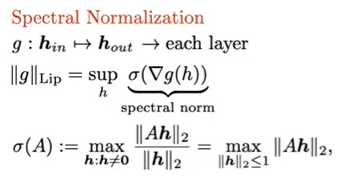
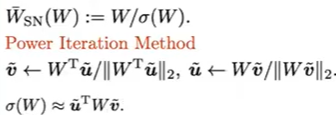
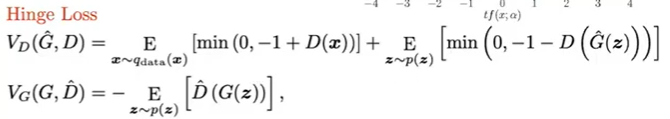
Image Credit: Maziar Raissi

In [21]:
# Spectral Normalisation code taken from the following website:
# https://github.com/christiancosgrove/pytorch-spectral-normalization-gan/blob/12dcf945a6359301d63d1e0da3708cd0f0590b19/spectral_normalization.py#L14



def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

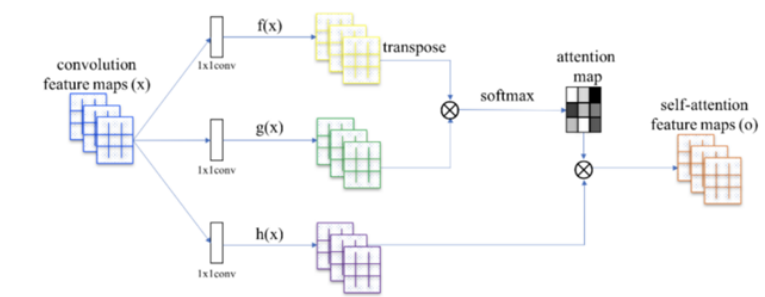
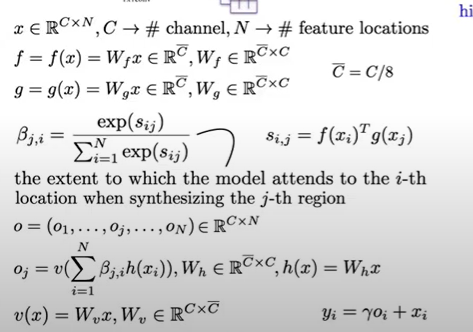

In [ ]:
#Self attention layer model
class Self_Attn(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        # Construct the module
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//2 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//2 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1)
        
    def forward(self,x):
        m_batchsize,C,width ,height = x.size()
        
        proj_query  = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0,2,1) # B * N * C
        proj_key =  self.key_conv(x).view(m_batchsize, -1, width*height) # B * C * N
        energy =  torch.bmm(proj_query, proj_key) # batch matrix-matrix product
        
        attention = self.softmax(energy) # B * N * N
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height) # B * C * N
        out = torch.bmm(proj_value, attention.permute(0,2,1)) # batch matrix-matrix product
        out = out.view(m_batchsize,C,width,height) # B * C * W * H
        
        out = self.gamma*out + x
        return out, attention

In [19]:
#Generator and discriminator models
# Generator takes input a latent variable as before and returns a generated image with shape (batch_size, 1, 64, 64)

class Generator(nn.Module):
    def __init__(self, batch_size=64, attn=True, image_size=64, z_dim=100, conv_dim=64):
        super().__init__()
        self.attn = attn
        
        # Layer 1 turn 100 dims -> 512 dims, size 1 -> 4
        layer1 = []
        layer1.append(SpectralNorm(nn.ConvTranspose2d(in_channels = z_dim, out_channels = conv_dim*8, kernel_size = 4)))
        layer1.append(nn.BatchNorm2d(conv_dim*8))
        layer1.append(nn.ReLU())
        self.l1 = nn.Sequential(*layer1)
        
        # state size. 512 x 4 x 4

        layer2 = []
        layer2.append(SpectralNorm(nn.ConvTranspose2d(in_channels = conv_dim*8, out_channels = conv_dim*4, 
                                                      kernel_size = 4, stride = 2, padding = 1)))
        layer2.append(nn.BatchNorm2d(conv_dim*4))
        layer2.append(nn.ReLU())
        self.l2 = nn.Sequential(*layer2)

        # state size. 256 x 8 x 8
        layer3 = []
        layer3.append(SpectralNorm(nn.ConvTranspose2d(in_channels = conv_dim*4, out_channels = conv_dim*2, 
                                                      kernel_size = 4, stride = 2, padding = 1)))
        layer3.append(nn.BatchNorm2d(conv_dim*2))
        layer3.append(nn.ReLU())
        self.l3 = nn.Sequential(*layer3)
        
         # state size. 128 x 16 x 16


        self.attn1 = Self_Attn(conv_dim*2)
        #no change in state size
        layer4 = []
        layer4.append(SpectralNorm(nn.ConvTranspose2d(in_channels = conv_dim*2, out_channels = conv_dim, 
                                                      kernel_size = 4, stride = 2, padding = 1)))
        layer4.append(nn.BatchNorm2d(conv_dim))
        layer4.append(nn.ReLU())
        self.l4 = nn.Sequential(*layer4)
        
        # state size. 64 x 32 x 32
        

        self.attn2 = Self_Attn(conv_dim)
        #no change in state size
        
        layer5 = []
        layer5.append(nn.ConvTranspose2d(conv_dim, 3, 4, 2, 1))
        layer5.append(nn.Tanh())
        self.l5 = nn.Sequential(*layer5)
        # state size. 3 x 64 x 64

    def forward(self, z):
        # z is the input random matrix for generator
        z = z.view(z.size(0), z.size(1), 1, 1)
        out=self.l1(z)
        out=self.l2(out)
        out=self.l3(out)
        if self.attn == True:
            out,_ = self.attn1(out)
        out=self.l4(out)
        if self.attn == True:
            out,_ = self.attn2(out)
        out=self.l5(out)

        return out


#Discriminator inputs a batch of data of size (batch_size, 1, 64, 64) and returns a batch of 
# scalars indicating the predict results
class Discriminator(nn.Module):
    
    def __init__(self, batch_size=64, attn=True, image_size=64, conv_dim=64):
        super().__init__()
        self.attn = attn
        
        
        layer1 = []
        layer1.append(SpectralNorm(nn.Conv2d(3, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))
        curr_dim = conv_dim
        self.l1 = nn.Sequential(*layer1)
        
        # state size. 64 x 32 x 32

        layer2 = []
        layer2.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2
        self.l2 = nn.Sequential(*layer2)
        
        # state size. 128 x 16 x 16

        layer3 = []
        layer3.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2
        self.l3 = nn.Sequential(*layer3)
        # state size. 256 x 8 x 8
        

        self.attn1 = Self_Attn(curr_dim)
        #no change in state size
        

        layer4 = []
        layer4.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer4.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2
        self.l4 = nn.Sequential(*layer4)
        # state size. 512 x 4 x 4
        

        self.attn2 = Self_Attn(curr_dim)
        #no change in state size
        

        layer5 = []
        layer5.append(nn.Conv2d(curr_dim, 1, 4, 1, 0))
        self.l5 = nn.Sequential(*layer5)
        # state size. 1 x 1 x 1

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        if self.attn == True:
            out,_ = self.attn1(out)
        out = self.l4(out)
        if self.attn == True:
            out,_ = self.attn2(out)
        out = self.l5(out)

        return out.squeeze()


In [ ]:
batch_size = 64

# Utility functions
def cuda(data):
    if torch.cuda.is_available():
        return data.cuda()
    else:
        return data

def denorm(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)

IMAGE_SIZE = 64
CHANNELS_IMG = 3

dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE), #resizing to 64.
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
             [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
         ),
    ])
)


dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

# Fix a random latent input for samples
fixed_z = cuda(torch.randn(64, 100))

Files already downloaded and verified


In [ ]:
base_path = "./data/dataset/"
real_path = base_path + "real/"
fake_path = base_path + "fake/"
losses_G = []
losses_D = []
FID_list = []

def train(steps = 100000, batch_size = 64, z_dim = 100, attn = True):
    # Initialize model
    G = cuda(Generator(batch_size, attn))
    D = cuda(Discriminator(batch_size, attn))
    
    # Make directory for samples and models
    cwd = os.getcwd()
    post='_attn' if attn else ''
    if not os.path.exists(cwd+'/cifar10'+post):
        os.makedirs(cwd+'/cifar10'+post)

    # # two separate ADAM optimizers are set up, one for the generator, and one for the discriminator.
    g_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, G.parameters()), 0.0001, [0.0,0.9])
    d_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, D.parameters()), 0.0004, [0.0,0.9])
    
    # Load data
    Iter = iter(dataloader)
    
    # Start timer
    start_time = time.time()
    

#Conclusion from WGAN paper:
# Critic/Discriminator Loss = [average critic score on real images] – [average critic score on fake images]
# Generator Loss = -[average critic score on fake images]
# Where the average scores are calculated across a mini-batch of samples

    for step in range(steps):
        # ================== Train D ================== #
        D.train(); G.train()
        try:
            real_images,_ = next(Iter)
        except:
            Iter = iter(dataloader)
            real_images,_ = next(Iter)
        
        print(real_images.size())
        # Compute loss with real images
        d_out_real = D(cuda(real_images))
        d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
        
        # Compute loss with fake images
        z = cuda(torch.randn(batch_size, z_dim))
        fake_images = G(z)
        d_out_fake = D(fake_images)
        d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
        
        # Backward + Optimize
        d_loss = d_loss_real - d_loss_fake
        d_optimizer.zero_grad(); g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================== Train G ================== #
        # Create random noise
        z = cuda(torch.randn(batch_size, z_dim))
        fake_images = G(z)
        g_out_fake = D(fake_images)
        g_loss_fake = - g_out_fake.mean()
        d_optimizer.zero_grad(); g_optimizer.zero_grad()
        g_loss_fake.backward()
        g_optimizer.step()
        
        # Print out log info
        if (step + 1) % 10 == 0:
            elapsed = time.time() - start_time
            expect = elapsed/(step + 1)*(steps-step-1)
            elapsed = str(datetime.timedelta(seconds=elapsed))
            expect = str(datetime.timedelta(seconds=expect))
            clear_output(wait=True)
            print("Elapsed [{}], Expect [{}], step [{}/{}], D_real_loss: {:.4f}, "
                  " ave_generator_gamma1: {:.4f}, ave_generator_gamma2: {:.4f}".
                  format(elapsed,expect,step + 1,steps,d_loss.item(),
                         G.attn1.gamma.mean().item(),
                         G.attn2.gamma.mean().item()))
        
        # Sample images
        if (step + 1) % (100) == 0:
            fake_images= G(fixed_z)
            save_image(denorm(fake_images), os.path.join('./samples_celeba'+post, '{}_fake.png'.format(step + 1)))
        
        # Save models
        if (step+1) % (100) == 0:
            torch.save(G.state_dict(),os.path.join('./models', '{}_G.pth'.format(step + 1)))
            torch.save(D.state_dict(),os.path.join('./models', '{}_D.pth'.format(step + 1)))

In [ ]:
plt.figure(figsize=(10,5))
plt.title("FID Score")

plt.plot(new_list)
plt.xlabel("epochs")
plt.ylabel("FIDs")
plt.show()

In [ ]:
train(steps = 10000, attn = True)
print('Done training part 1')
train(steps = 10000, attn = False)
print('Done training part 2')

In [ ]:
print(len(img_list))

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
testloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False
)

def real_images():
    for i, data in enumerate(testloader, 0):
        real_inputs = data[0].detach().cpu()
        save_image(real_inputs, real_path + 'img' + str(i) + '.png')
        if i % 1000 == 0:
            print(i)

real_images()